In [1]:
import os
import copy
import time
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import itertools
from torch.autograd import Variable
import sklearn, sklearn.model_selection, sklearn.metrics
import numpy as np
from scipy import sparse
from models.models import MLP, GCN, SLR
from data import datasets
from data.gene_graphs import GeneManiaGraph
from data.utils import record_result

%load_ext autoreload
%autoreload 2
torch.cuda.set_device(1)

In [2]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Converting one-hot labels to integers


In [3]:
# Setup the results dictionary
filename = "experiments/results/fig-5-jan21.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'num_genes', 'seed', 'train_size', 'time_elapsed'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [15]:
results.groupby(["gene", "model", "num_genes"]).mean()

auc
gene model                                         num_genes          
RPL4 GCN_lay20_chan32_emb32_dropout_pool_hierarchy 50         0.500000
                                                   100        0.500000
                                                   200        0.500000
                                                   300        0.500000
                                                   500        0.500000
                                                   1000       0.500000
                                                   2000       0.500000
                                                   4000       0.500000
                                                   8000       0.499306
                                                   16300      0.502103
     GCN_lay3_chan64_emb32_dropout                 50         0.865643
                                                   100        0.895264
                                                   200        0.902974
                                                   300        0.883672
                                                   500        0.893002
                                                   1000       0.842708
                                                   2000       0.827751
                                                   4000       0.767067
                                                   8000       0.716720
                                                   16300      0.688506
     GCN_lay3_chan64_emb32_dropout_pool_hierarchy  50         0.691262
                                                   100        0.579683
                                                   200        0.613088
                                                   300        0.725107
                                                   500        0.687794
                                                   1000       0.697080
                                                   2000       0.678811
                                                   4000       0.670673
                                                   8000       0.688186
                                                   16300      0.658031
     MLP_lay2_chan512                              50         0.862865
                                                   100        0.882888
                                                   200        0.904256
                                                   300        0.897293
                                                   500        0.890046
                                                   1000       0.871590
                                                   2000       0.836921
                                                   4000       0.804327
                                                   8000       0.759927
                                                   16300      0.732016
     MLP_lay2_chan512_dropout                      50         0.869783
                                                   100        0.884936
                                                   200        0.904131
                                                   300        0.897569
                                                   500        0.891658
                                                   1000       0.875027
                                                   2000       0.834268
                                                   4000       0.789628
                                                   8000       0.764441
                                                   16300      0.723362
RPL5 GCN_lay20_chan32_emb32_dropout_pool_hierarchy 50         0.500000
                                                   100        0.500000
                                                   200        0.500000
                                                   300        0.500000
                                                   500        0.500000
                    

In [5]:
gene_graph = GeneManiaGraph()

Torrent name: genemania.pkl, Size: 9.61MB


In [13]:
search_num_genes=[50, 100, 200, 300, 500, 1000, 2000, 4000, 8000, 16000]
test_size=300
search_train_size=[50]
cuda=True
trials=3
search_genes = ["RPL4", "RPL5", "RPS10", "RPS3", "CEBPD", "IL5", "PABPC3", "PSMB10", "S100A8", "S100A9", "TOP1", "C15orf40", "RNF138", "DLGAP2", "EVI2B", "ZFP82", "MYBL2", "PSMB1", "CISD1", "HLA-B", "SAA2", "IFIT1", "RPS3A", "TP53", "TNF", "EGFR"]
models = [       
               #GCN(name="GCN_lay20_chan32_emb32_dropout_pool_hierarchy", cuda=cuda, dropout=True, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="hierarchy"),
               GCN(name="GCN_lay3_chan64_emb32_dropout_pool_hierarchy", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32, pooling="hierarchy"),               
              #GCN(name="GCN_lay20_chan32_emb32_dropout_pool_random", cuda=cuda, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="random"),
               GCN(name="GCN_lay3_chan64_emb32_dropout", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32),
               MLP(name="MLP_lay2_chan512_dropout", cuda=cuda, dropout=True, num_layer=2, channels=512),
              # MLP(name="MLP_lay2_chan512", cuda=cuda, dropout=False, num_layer=2, channels=512),
#               SLR(name="SLR_lambda1_l11", cuda=cuda)
             ]

In [14]:
# Create the set of all experiment ids and see which are left to do
model_names = [model.name for model in models]
columns = ["gene", "model", "num_genes", "train_size", "seed"]
all_exp_ids = [x for x in itertools.product(search_genes, model_names, search_num_genes, search_train_size, range(trials))]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")
print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 2259
done: 301


In [16]:
def get_every_n(a, n=2):
    for i in range(a.shape[0] // 2):
        yield a[2*i:2*(i+1)]


In [17]:
for row in todo:
    print(row)
    start_time = time.time()
    gene = row["gene"]
    model_name = row["model"]
    seed = row["seed"]
    num_genes = row["num_genes"] if row["num_genes"] < 10000 else 16300
    train_size = row["train_size"]
    model = [copy.deepcopy(model) for model in models if model.name == row["model"]][0]

    experiment = {
        "gene": gene,
        "model": model.name,
        "num_genes": num_genes,
        "train_size": train_size,
        "seed": seed,
    }

    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
    if num_genes == 16300:
        neighbors = gene_graph.nx_graph
    else:
        neighbors = gene_graph.bfs_sample_neighbors(gene, num_genes)

    X_train = X_train[list(neighbors.nodes)].copy()
    X_test = X_test[list(neighbors.nodes)].copy()
    Xii_train[gene] = 1
    X_test[gene] = 1
    adj = np.asarray(nx.to_numpy_matrix(neighbors))
    model.fit(X_train, y_train, adj=adj)
    
    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
    if cuda:
        x_test = x_test.cuda()
    
    y_hat = []
    for chunk in get_every_n(x_test, 10):
        y_hat.extend(model.predict(chunk)[:,1].data.cpu().numpy().tolist())
    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())

    del model
    experiment["auc"] = auc
    experiment["time_elapsed"] = str(time.time() - start_time)
    results = record_result(results, experiment, filename)
    print(experiment)


{'gene': 'RPL4', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'num_genes': 16000, 'train_size': 50, 'seed': 0}
setup layers took: 29.461077451705933
epoch: 0 0.556100606918335
epoch: 1 0.2163562774658203
epoch: 2 0.20980358123779297
epoch: 3 0.22450804710388184
epoch: 4 0.20921540260314941
epoch: 5 0.20924878120422363
epoch: 6 0.21363353729248047
epoch: 7 0.20920801162719727
epoch: 8 0.2101738452911377
epoch: 9 0.20921826362609863
epoch: 10 0.20969247817993164
epoch: 11 0.20952153205871582
epoch: 12 0.2096707820892334
epoch: 13 0.2100052833557129
epoch: 14 0.2103865146636963
epoch: 15 0.21113109588623047
total train time:13.847397327423096 for epochs: 16
{'gene': 'RPL4', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'num_genes': 16300, 'train_size': 50, 'seed': 0, 'auc': 0.7030804843304843, 'time_elapsed': '51.59653329849243'}
{'gene': 'RPL4', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'num_genes': 16000, 'train_size': 50, 'seed': 1}
setup layers to

RuntimeError: CUDA out of memory. Tried to allocate 39.88 MiB (GPU 1; 10.92 GiB total capacity; 9.80 GiB already allocated; 35.50 MiB free; 419.71 MiB cached)

In [10]:
results

,auc,gene,model,num_genes,seed,train_size,time_elapsed
0,0.652822,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,50,0,50,22.944617986679077
1,0.654247,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,50,0,50,16.566932916641235
2,0.612402,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,50,1,50,18.058260202407837
3,0.669115,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,50,2,50,19.65968918800354
4,0.729167,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,50,3,50,32.638742446899414
5,0.829817,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,50,4,50,3.580824136734009
6,0.624866,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,100,0,50,2.8438425064086914
7,0.574742,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,100,1,50,3.1366865634918213
8,0.582977,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,100,2,50,2.151219367980957
9,0.557737,RPL4,GCN_lay3_chan64_emb32_dropout_pool_hierarchy,100,3,50,2.113729476928711


In [10]:
0 % 1

0

In [10]:
results

,auc,gene,model,num_genes,seed,train_size,time_elapsed
0,0.575046,RPL4,GCN_lay3_chan64_emb32_dropout,50,0,50,35.51251173019409
1,0.500000,RPL4,GCN_lay3_chan64_emb32_dropout,50,1,50,6.390526533126831
2,0.544952,RPL4,GCN_lay3_chan64_emb32_dropout,50,2,50,3.7114007472991943
3,0.500721,RPL4,GCN_lay3_chan64_emb32_dropout,50,3,50,3.427546977996826
4,0.497917,RPL4,GCN_lay3_chan64_emb32_dropout,50,4,50,3.657351016998291
5,0.466869,RPL4,GCN_lay3_chan64_emb32_dropout,100,0,50,3.0078303813934326
6,0.469764,RPL4,GCN_lay3_chan64_emb32_dropout,100,1,50,2.4217426776885986
7,0.500000,RPL4,GCN_lay3_chan64_emb32_dropout,100,2,50,4.3778393268585205
8,0.500000,RPL4,GCN_lay3_chan64_emb32_dropout,100,3,50,4.056507587432861
9,0.476294,RPL4,GCN_lay3_chan64_emb32_dropout,100,4,50,2.8931021690368652


In [7]:
row = todo[0]
print(row)
start_time = time.time()
gene = row["gene"]
model_name = row["model"]
seed = row["seed"]
num_genes = 2000
train_size = row["train_size"]

model = [x for x in models if x.name == model_name][0]

experiment = {
    "gene": gene,
    "model": model.name,
    "num_genes": num_genes,
    "train_size": train_size,
    "seed": seed,
}

dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

neighbors = gene_graph.bfs_sample_neighbors(gene, num_genes)

X_train = X_train[list(neighbors.nodes)].copy()
X_test = X_test[list(neighbors.nodes)].copy()
X_train[gene] = 1
X_test[gene] = 1
adj = np.asarray(nx.to_numpy_matrix(neighbors))


{'model': 'GCN_lay1_chan64_emb32_dropout_agg', 'seed': 0, 'num_genes': 4000, 'gene': 'IL5', 'train_size': 50}


206


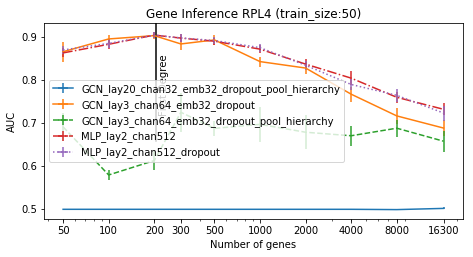

219


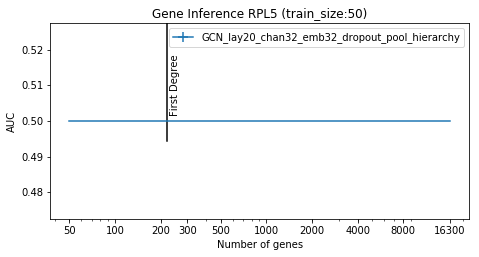

167


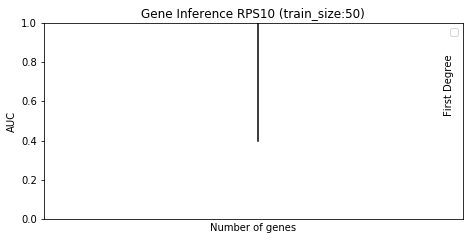

250


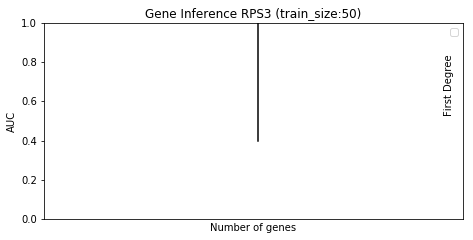

34


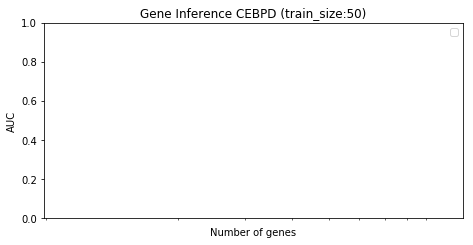

3


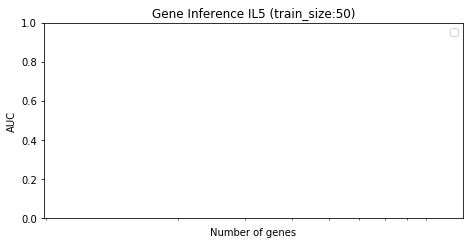

23


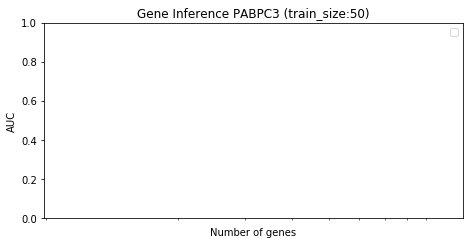

24


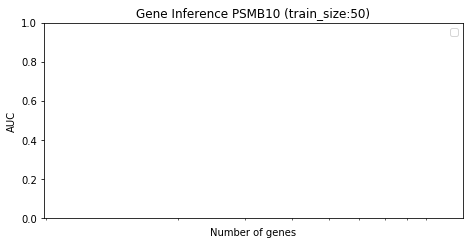

57


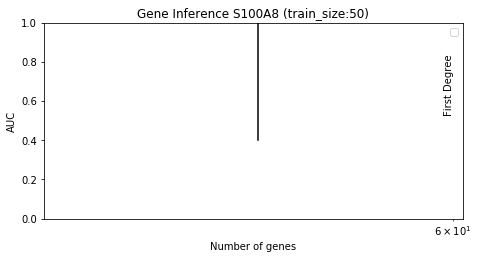

85


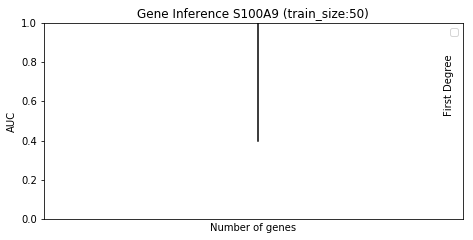

158


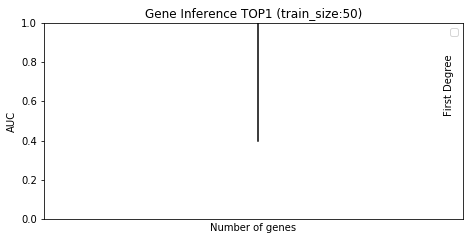

3


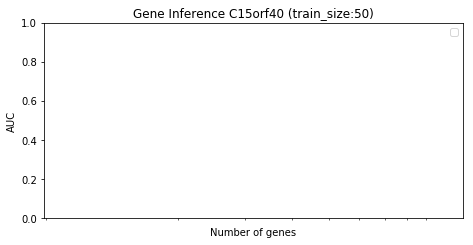

26


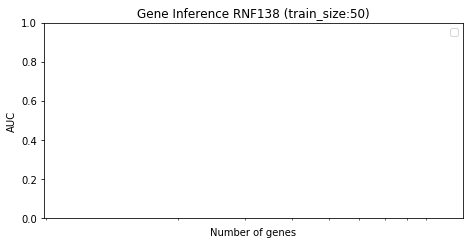

24


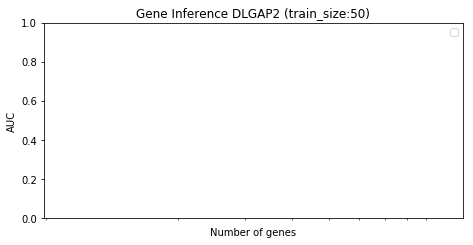

1


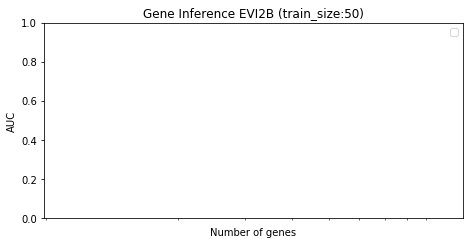

1


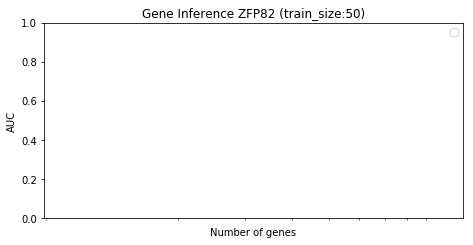

53


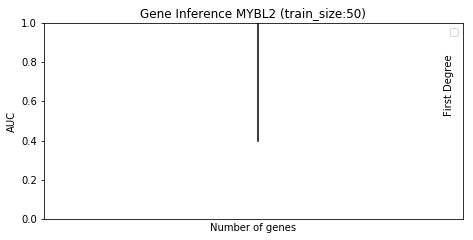

131


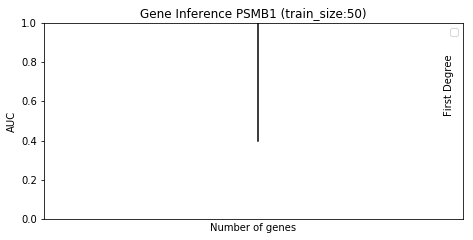

33


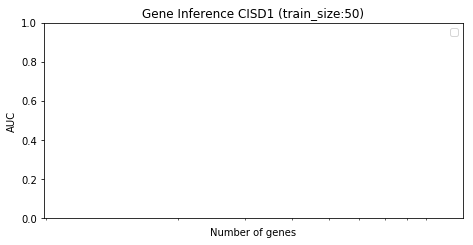

73


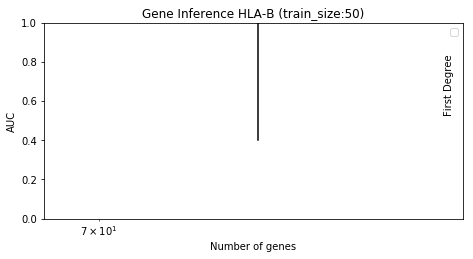

3


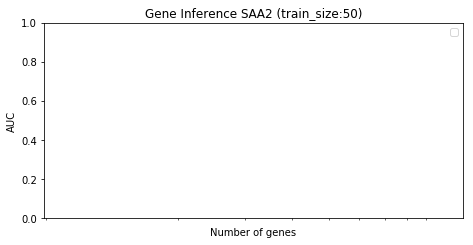

49


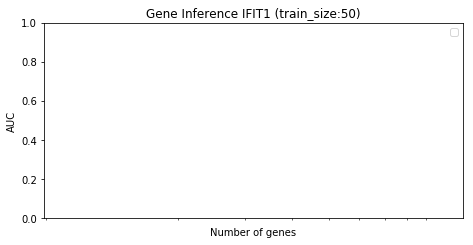

230


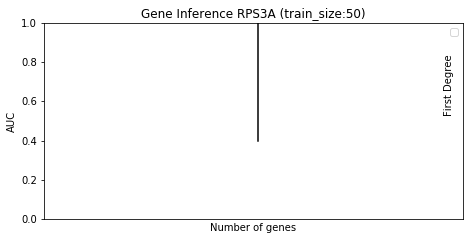

938


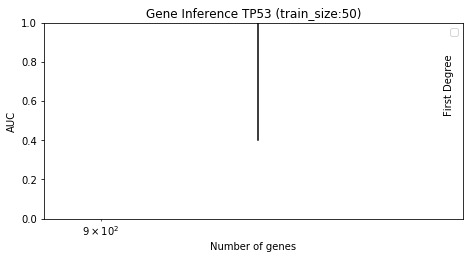

122


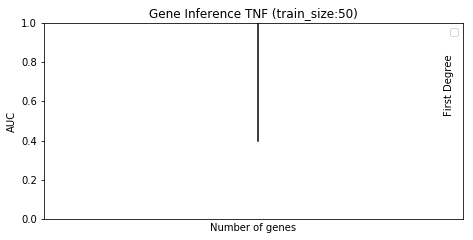

922


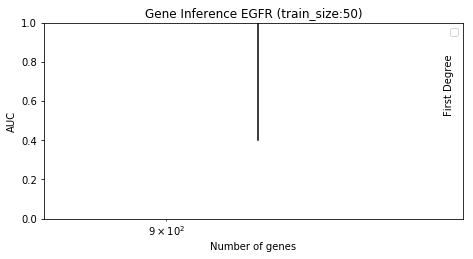

In [12]:

for plot_gene in search_genes:

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (7.5, 3.6)
    plot_train_size = 50

    subset = results[(results.train_size==plot_train_size) & 
                      (results.gene==plot_gene) & 
                      (results.num_genes!=400) &      
                      (results.num_genes> 0)]


    q = subset.groupby(['model','num_genes'])['auc']

    todo = list(subset["model"].unique())
    linestyles = ['-', '-', '--', '-.', ':']
    for ls, model in enumerate(sorted(todo)):
        index = list(q.mean()[model].index)
        mean = q.mean()[model]
        stderr = q.std()[model]/np.sqrt(q.count()[model])
        displayname = model.replace("CGN","GCN")
        displayname = displayname.replace("SLR", "SNLR")
        plt.errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls=linestyles[ls])

    plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
    plt.ylabel("AUC")
    plt.xlabel("Number of genes")
    plt.xscale("log")
    plt.xticks(sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter()
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.legend();
    fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
    print(fd)
    if fd > 50:
        plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
        c = plt.ylim()
        plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)


    plt.savefig("experiments/results/sgi-" + plot_gene + "-" + "train" + str(plot_train_size) + ".png", bbox_inches='tight')
    plt.show()